# University of Michigan, NA/EECS 568, ROB 530
# Mobile Robotics: Methods & Algorithms, Winter 2024

## Homework 2 $-$ Nonlinear Filtering & InEKF

- **See the course Canvas for syllabus, due dates, and homework and grading policies.**
- This course utilizes an autograder to evaluate homework. For each of the five problems, carefully read the submission instructions and complete the TODOs in the corresponding Python script. Once you have finished coding, upload all scripts to GradeScope for automatic assessment and grading. Please note, the autograder retains only the latest score, not the highest.
- For each problem, the autograder will check the **return value** of the function you implement. Additionally, the variables are printed in this notebook for you to review.

In [132]:
# run this block to enable autoreload of modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Problem 1. Nonlinear Filtering (60 points)

#### Problem Setup
We are given a setup, shown below, to estimate the 3D position of an object's center. The object is stationary, and there are also two fixed monocular cameras in the room. A previously developed object detection algorithm can provide the object's center in the 2D image coordinates. However, the depth is not observable by a single RGB image. Therefore, our goal is to combine measurements from two cameras to estimate the object's 3D position in the frame of camera 1. The relative pose (orientation and translation) between the two cameras is accurately known and given.

![setup](problem1_setup.png)

One of your colleagues (who is good at math and modeling!) has already formulated the problem. But he has very poor knowledge of state estimation, which is why he reached out to you for the rest of the solution. Luckily, you are taking the Mobile Robotics class, and you can help him out this time, so he doesn't lose his job! So far, we have the following.


#### Measurement Models
From elementary computer vision knowledge, we know that a monocular pinhole camera model takes the following form


\begin{align*}
\begin{bmatrix}
u \\
v
\end{bmatrix} =
\begin{bmatrix}
f_x & 0 \\
0 & f_y
\end{bmatrix} \cdot  \frac{1}{p_z} \cdot
\begin{bmatrix}
p_x \\ p_y
\end{bmatrix} +
\begin{bmatrix}
c_x \\
c_y
\end{bmatrix}
= K_f \pi(p) + c,
\end{align*}


where $K_f =
\begin{bmatrix}
f_x & 0 \\
0 & f_y
\end{bmatrix}$ is called intrinsic camera matrix,$
\begin{bmatrix}
    c_x \\
    c_y
\end{bmatrix}
$ is the coordinates of the optical center of the image, and $\pi(\cdot)$ is the projection function (it takes a point and divides its coordinates by $z$, i.e., the last coordinate).

We denote the object's center in frame 1 by ${^1p}$ and ${^2p}$ as the object's center in frame 2. Given the rotation matrix, $R$, and the translation vector, $t$ of frame 2 with respect to frame 1, we have the following relationship for the object's center between the two frames.
$${^1p} = R  \cdot {^2p} + t,$$
and $${^2p} = R^\top \cdot {^1p} - R^\top t .$$

Combining everything so far, we have the following measurement models for camera 1
\begin{equation*}
    z = \begin{bmatrix}
    u \\
    v
    \end{bmatrix} = {^1K_f} \pi({^1p})+{^1c} := h_1({^1p}),
\end{equation*}
and camera 2
\begin{equation*}
    z = \begin{bmatrix}
    u \\
    v
    \end{bmatrix} = {^2K_f} \pi({^2p})+{^2c} = {^2K_f} \pi(R^\top  \cdot {^1p} - R^\top t)+{^2c} =: h_2({^1p}).
\end{equation*}
We also assume each measurement model is corrupted by a zero-mean white Gaussian noise.
\begin{align*}
    z_1 &= h_1({^1p}) + v_1, \quad v_1 \sim \mathcal{N}(0,\Sigma_{v_1}), \\
    z_2 &= h_2({^1p}) + v_2, \quad v_2 \sim \mathcal{N}(0,\Sigma_{v_2}). \\
\end{align*}
We may also stack two synchronized observations to form a stacked observation model as follows.
\begin{align*}
z = \begin{bmatrix}
    z_1 \\ z_2
    \end{bmatrix}_{4\times 1} = \begin{bmatrix}
    h_1({^1p}) \\ h_2({^1p})
    \end{bmatrix}_{4\times 1} + \begin{bmatrix}
    v_1 \\ v_2
    \end{bmatrix}_{4\times 1} =: h({^1p}) + v,
\end{align*}
where now $v \sim \mathcal{N}\left( 0_{4\times 1},\mathrm{blkdiag}(\Sigma_{v_1},\Sigma_{v_2})\right)$, and $\mathrm{blkdiag}(\cdot)$ forms a block diagonal matrix.


#### Motion Model
Furthermore, camera 1 is attached to a structure that can vibrate. The vibration is not so severe that we assume the camera moves, but to account for inaccuracies caused by the fixture vibration we use a discrete-time random walk process as its motion model.
$${^1p}_{k+1} = {^1p}_k + w, \quad w \sim \mathcal{N}(0,\Sigma_{w}).$$

#### Jacobians
The Jacobians are also given using the chain rule and the fact that if $q = R^\top p- R^\top t$, then $\frac{\partial q}{\partial p}=R^\top$ (you may use a symbolic math software to compute the Jacobians as well). In the following we use ${^1p} = \begin{bmatrix} p_x & p_y & p_z \end{bmatrix}^\top$ and ${^2p} = \begin{bmatrix} q_x & q_y & q_z \end{bmatrix}^\top$.

\begin{align*}
H_1 = \frac{\partial h_1}{\partial ~{^1p}} = K_f \frac{\partial \pi}{\partial ~{^1p}} = K_f \begin{bmatrix}
    \frac{1}{p_z} & 0 & -\frac{p_x}{p_z^2}\\
    0 & \frac{1}{p_z} & -\frac{p_y}{p_z^2}
    \end{bmatrix},
\end{align*}


\begin{align*}
H_2 = \frac{\partial h_2}{\partial ~{^1p}} = K_f \frac{\partial \pi}{\partial ~{^1p}} = K_f \frac{\partial \pi}{\partial ~{^2p}} \cdot \frac{\partial ~{^2p}}{\partial ~{^1p}} = K_f \begin{bmatrix}
    \frac{1}{q_z} & 0 & -\frac{q_x}{q_z^2}\\
    0 & \frac{1}{q_z} & -\frac{q_y}{q_z^2}
    \end{bmatrix} R^\top
\end{align*}

and the stacked measurement Jacobian can also be constrcuted as

$$H_{4\times 3} = \begin{bmatrix} H_1 \\ H_2 \end{bmatrix}$$


#### Provided Data Format
The processed measurements are provided in .mat and .csv files. Both files contain the same data. Unfortunately, there is no knowledge about the noise covariances, and tuning these parameters must be done manually as part of your implementation.

In the provided data,
- Kf\_1 and Kf\_2 are the intrinsic camera matrices for two cameras.
- C\_1 and C\_2 are the coordinates of the optical center of the image for two cameras.
- z\_1 and z\_2 are the 20 observations in the form of (u, v) for two cameras.
- R and t are the rotation matrix and the translation vector of camera 2 with respect to camera 1.


**Remark:** Generally speaking, the batch update is expected to be more accurate than the sequential update, especially for EKF. This is because in a sequential update, after each correction, the linearization point is changed. The Jacobian of the next correction is not evaluated at the same point as the previous correction. This process might cause unexpected outcomes, depending on the problem. In the batch case, all information is incorporated into the filter at once.

#### 1.a EKF (30 points)
Develop an EKF to solve the problem using
- A sequential measurement update that applies camera 1's correction first followed by camera 2's correction.
- A batch measurement update using the stacked measurement model.

#### Submission
Please fill the **TODO**s in the function contained in **nonlinear_filtering_ekf.py** and submit the file to gradescope.

#### Instructions

1. Derive and implement `process_model, measurement_model, measurement_Jacobain` functions (6 points)
2. Implement `prediction, correction1, correction2` methods of `extended_kalman_filter` class. (6 points)
3. Implement `ekf_sequential` function. (6 points)
4. Implement `correction_batch` method of `extended_kalman_filter` class. (6 points)
5. Implement `ekf_batch` function. (6 points)

Your code is evaluated at each step using test input independently. Specifically, during steps 3 and 5, the autograder will use the correct `extended_kalman_filter` class to test your code. For example, even if the `prediction` method from step 2 is incorrect, implementing `ekf_sequential` correctly in step 3 can still earn you full credits.

In [133]:
from nonlinear_filtering_ekf import *
import numpy as np
import matplotlib.pyplot as plt

#### EKF with sequential updates

Answer for Problem 1a (sequential):
Final x: 0.2790, y: 0.1916, z: 1.9689


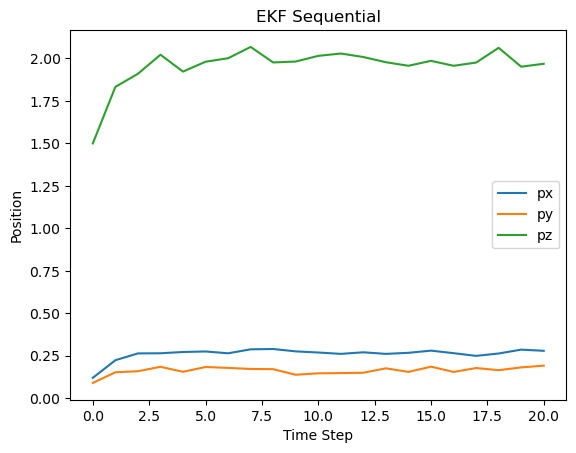

In [134]:
data = ekf_load_data()
ekf = extended_kalman_filter(data)
states = ekf_sequential(ekf, data).squeeze()

# print final state
print('Answer for Problem 1a (sequential):')
print('Final x: %.4f, y: %.4f, z: %.4f' % (states[-1,0], states[-1,1], states[-1,2]))
# plotting
fig = plt.figure()
plt.plot(states[:, 0], label='px')
plt.plot(states[:, 1], label='py')
plt.plot(states[:, 2], label ='pz')
plt.xlabel(r'Time Step')
plt.ylabel(r'Position')
plt.legend()
plt.title('EKF Sequential')
plt.show()

#### EKF with batch updates

Answer for Problem 1a (batch):
Final x: 0.2808, y: 0.1905, z: 1.9669


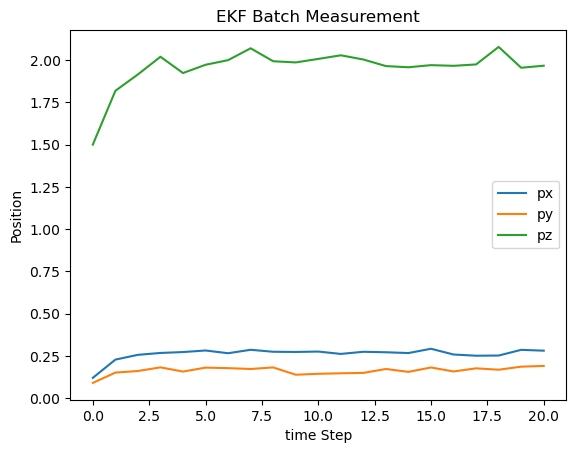

In [135]:
data = ekf_load_data()
ekf = extended_kalman_filter(data)
states = ekf_batch(ekf, data).squeeze()

# print final state
print('Answer for Problem 1a (batch):')
print('Final x: %.4f, y: %.4f, z: %.4f' % (states[-1,0], states[-1,1], states[-1,2]))
# plotting
fig = plt.figure()
plt.plot(states[:, 0], label='px')
plt.plot(states[:, 1], label='py')
plt.plot(states[:, 2], label ='pz')
plt.xlabel(r'time Step')
plt.ylabel(r'Position')
plt.legend()
plt.title('EKF Batch Measurement')
plt.show()

#### 1.b Particle Filter (30 points)
Develop a particle filter to solve the problem using
- A sequential measurement update that applies camera 1's correction first followed by camera 2's correction.
- A batch measurement update using the stacked measurement model.

#### Submission
Please fill the **TODO**s in the function contained in **nonlinear_filtering_pf.py** and submit the file to gradescope.

#### Instructions

1. Derive and implement `process_model, measurement_model` functions (6 points)
2. Implement `sample_motion, importance_measurement_1, importance_measurement_2` methods of `particle_filter` class. (6 points)
3. Implement `pf_sequential` function. (6 points)
4. Implement `importance_measurement_batch` method of `particle_filter` class. (6 points)
5. Implement `pf_batch` function. (6 points)

Your code is evaluated at each step using test input independently. Specifically, during steps 3 and 5, the autograder will use the correct `particle_filter` class to test your code. For example, even if the `sample_motion` method from step 2 is incorrect, implementing `pf_sequential` correctly in step 3 can still earn you full credits.

In [136]:
from nonlinear_filtering_pf import *

#### PF with sequential updates

In [137]:
# set the seed for reproducibility
np.random.seed(seed=42)
data = pf_load_data()
pf = particle_filter(data)
states = pf_sequential(pf, data)

# print final state
print('Answer for Problem 1b (sequential):')
print('Final x: %.4f, y: %.4f, z: %.4f' % (states[-1, 0], states[-1, 1], states[-1, 2]))

fig = plt.figure()
plt.plot(states[:, 0], label='px')
plt.plot(states[:, 1], label='py')
plt.plot(states[:, 2], label='pz')
plt.title('Particle Filter Sequential')
plt.xlabel(r'time step')
plt.ylabel(r'Position')
plt.legend()
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


TypeError: only size-1 arrays can be converted to Python scalars

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "d:\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Alex\AppData\Local\Temp\ipykernel_46944\1882208063.py", line 5, in <module>
    states = pf_sequential(pf, data)
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Alex\OneDrive\桌面\OneDrive\ROB-530\Homework\HW2\nonlinear_filtering_pf.py", line 222, in pf_sequential
    pf.importance_measurement_1(z_1[i].reshape(-1, 1))
  File "c:\Users\Alex\OneDrive\桌面\OneDrive\ROB-530\Homework\HW2\nonlinear_filtering_pf.py", line 137, in importance_measurement_1
    self.p['w'][i] = multivariate_normal.pdf(v, mean=np.zeros(2), cov=self.R1)  # Update weight
    ~~~~~~~~~~~^^^
ValueError: setting an array element with a sequence.

During handling of the above exceptio

#### PF with batch updates

In [138]:
# set the seed for reproducibility
np.random.seed(seed=42)
data = pf_load_data()
pf = particle_filter(data)
states = pf_batch(pf, data)

# print final state
print('Answer for Problem 1b (batch):')
print('Final x: %.4f, y: %.4f, z: %.4f' % (states[-1, 0], states[-1, 1], states[-1, 2]))

fig = plt.figure()
plt.plot(states[:, 0], label='px')
plt.plot(states[:, 1], label='py')
plt.plot(states[:, 2], label='pz')
plt.title('Particle Filter Batch ')
plt.xlabel(r'time Step')
plt.ylabel(r'Position')
plt.legend()
plt.show()

AttributeError: 'particle_filter' object has no attribute 'importance_measurement_batch'

### Problem 2. Attitude and Heading Reference System (AHRS) (40 points + 20 points bonus)

In this problem, you will implement a Right-Invariant EKF (RI-EKF) on $\mathrm{SO}(3)$ to estimate the sensor frame orientation wrt the world frame. An Inertial Measurement Unit (IMU), shown below, is a highly useful sensor that consists of a gyroscope, an accelerometer, and often a magnetometer as well as a barometer (to measure the pressure). The gyroscope measures the angular velocity in the body/sensor frame. The accelerometer measures linear acceleration in the body frame. The magnetometer measures the local magnetic field, providing an absolute reference for the heading angle. An AHRS is an onboard system that consists of an IMU and often an EKF to estimate the sensor orientation by fusing the mentioned measurements.

![IMU](VN100.jpg)

In this problem, we only recorded the raw gyroscope and accelerometer measurements from a real VN-100 IMU. We also recorded the estimated orientation provided by the embedded EKF developed by the manufacturer. Since the estimated orientation is highly optimized for this sensor and is accurate (uses all onboard sensors and factory calibration/filtering of the signals), we use it as a proxy for the ground truth. For more information about the sensor, refer to its user manual and datasheet.

The **process model** of the RI-EKF will integrate gyroscope measurements. Let $R_t \in \mathrm{SO}(3)$ be the state variable that shows the sensor frame orientation wrt the world frame. The dynamics is

\begin{align*}
\dot{R}_t &= R_t (\tilde{\omega}_t - w_t^g)^\wedge ,
\end{align*}

where $\tilde{\omega}_t$ is the gyroscope reading and $w_t^g$ is the gyroscope noise modeled as a zero-mean white Gaussian process.
The **correction model** uses the accelerometer as follows.
\begin{equation*}
Y_{t_k} = R_{t_k}^{\top} g + V_{t_k},
\end{equation*}
where $g$ is the constant gravity vector (used as a reference) and $V_{t_k}$ is a vector of Gaussian noise. Here $Y_{t_k} = a_{t_k}$, where $a_{t_k}$ is the provided linear acceleration measurement. This observation model is clearly right-invariant.

#### Provided Data Format

The raw gyroscope and accelerometer measurements and ground truth orientation are provided in .mat and .csv files. Both files contain the same data. In the provided data,
- a is the accelerometer readings.
- omega is the gyroscope readings.
- dt is the time difference (delta time) at each step in seconds.
- g is the gravity vector.
- euler\_gt is the ground truth orientation as ZYX Euler angles.

#### 2.a RI-EKF (40 points)
Implement the RI-EKF and run the filter using provided IMU data.

#### Submission
Please fill the **TODO**s in the function contained in **ahrs_riekf.py** and submit the file to gradescope.

#### Instructions

1. Derive and implement the `motion_model` and `measurement_Jacobain` functions (16 points)
2. Implement the `prediction` and `correction` methods in the `right_iekf` class. (16 points)
3. Implement the `ahrs_riekf` funtion. (8 points)

Your code is evaluated at each step using test input independently. Specifically, during step 2, the autograder will use the correct `motion_model` and `measurement_Jacobain` to test your methods; during step 3, the autograder will use the correct `right_iekf` class to test your funtion.

Answer for Problem 2a:
Final x: 0.0000, y: 0.0000, z: 3.1416


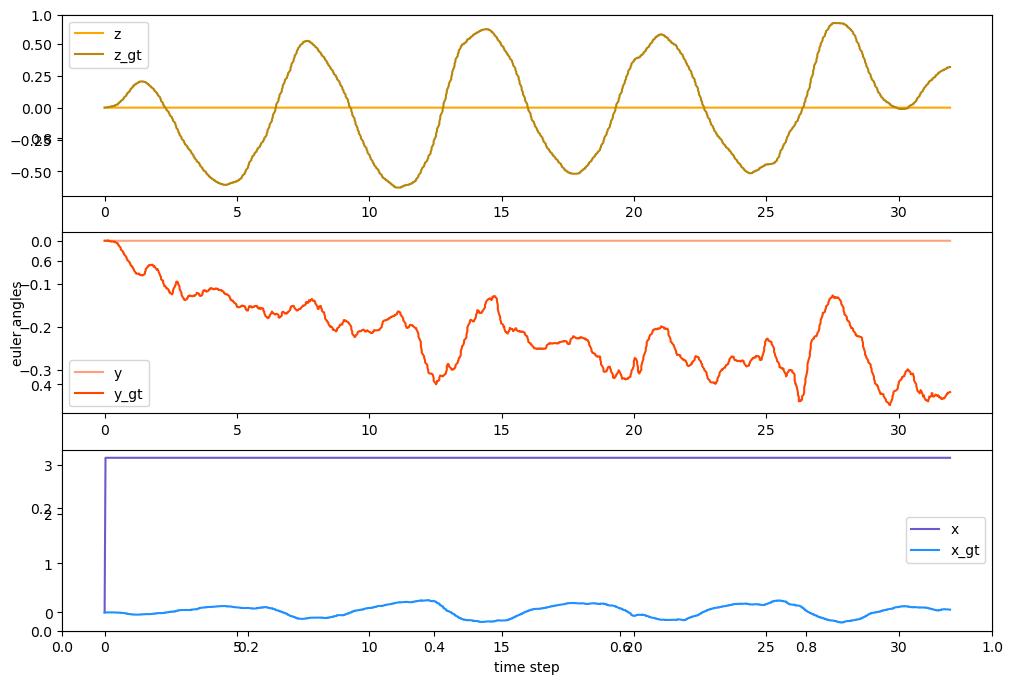

In [ ]:
from ahrs_riekf import *
import numpy as np
import matplotlib.pyplot as plt

data = riekf_load_data()
iekf_filter = right_iekf()
states_euler = ahrs_riekf(iekf_filter, data)

dt = data['dt']
euler_gt = data['euler_gt']

# print final state
print('Answer for Problem 2a:')
print('Final x: %.4f, y: %.4f, z: %.4f' % (states_euler[-1,0], states_euler[-1,1], states_euler[-1,2]))

# plotting
fig = plt.figure(figsize=(12,8))
time = np.concatenate(([0],np.cumsum(dt)))
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(time, states_euler[:, 0], label="z", color='orange')
ax1.plot(time, euler_gt[:, 0], label="z_gt", color='darkgoldenrod')
ax2.plot(time, states_euler[:, 1], label="y", color='lightsalmon')
ax2.plot(time, euler_gt[:, 1], label="y_gt", color='orangered')
ax3.plot(time, states_euler[:, 2], label="x", color='slateblue')
ax3.plot(time, euler_gt[:, 2], label="x_gt", color='dodgerblue')

ax1.legend()
ax2.legend()
ax3.legend()

ax.set_xlabel('time step')
ax.set_ylabel('euler angles')

plt.show()


#### 2.b Imperfect RI-EKF (20 points bonus)
Unfortunately, the sensor and motion models are not perfect. The accelerometer measurement is corrupted with bias. Therefore, we may incorporate a bias state. A simple way is to model the bias as being driven only by zero-mean white Gaussian noise. Thus, we have the new extended state model:

\begin{align*}
\dot{R}_t &= R_t (\tilde{\omega}_t - w_t^g)^\wedge , \\
\dot{b}_t &= w_t^{b},
\end{align*}

where $b_t \in \mathbb{R}^3$ is the accelerometer bias and $w_t^{b}$ is a zero-mean white Gaussian noise. We have the observation model as follows.

\begin{equation*}
Y_{t_k} = R_{t_k}^{\top} g + b_t + V_{t_k}.
\end{equation*}

Note that due to the extended state $b_t$, the observation model is no longer right invariant. Thus, we may call it the imperfect RI-EKF.

Derive all the equations for the implementation of the imperfect RI-EKF and implement the filter.

**Hints:** Concatenate the linearized $R_t$ dynamics on $SO(3)$ with $b_t$ dynamics in $\mathbb{R}^3$ for the prediction step. The new observation model is not right invariant due to the bias; derive the update steps as conventional EKF with residual defined in vector space. You may refer to Section 7 of this paper:
- [Hartley R, Ghaffari M, Eustice RM, Grizzle JW. Contact-aided invariant extended Kalman filtering for robot state estimation. The International Journal of Robotics Research. 2020 Mar; 39(4):402-30.](https://journals.sagepub.com/doi/pdf/10.1177/0278364919894385)

#### Submission
Please fill the **TODO**s in the function contained in **ahrs_imperfect_riekf.py** and submit the file to gradescope.

#### Instructions

1. Derive and implement the `motion_model` and `measurement_Jacobain` functions (8 points)
3. Implement the `prediction` and `correction` methods in the `imperfect_right_iekf` class. (8 points)
5. Implement the `ahrs_imperfect_riekf` funtion. (4 points)

Your code is evaluated at each step using test input independently. Specifically, during step 2, the autograder will use the correct `motion_model` and `measurement_Jacobain` to test your methods; during step 3, the autograder will use the correct `imperfect_right_iekf` class to test your funtion.

Answer for Problem 2b:
Final x: 0.0000, y: 0.0000, z: 3.1416


<Figure size 640x480 with 0 Axes>

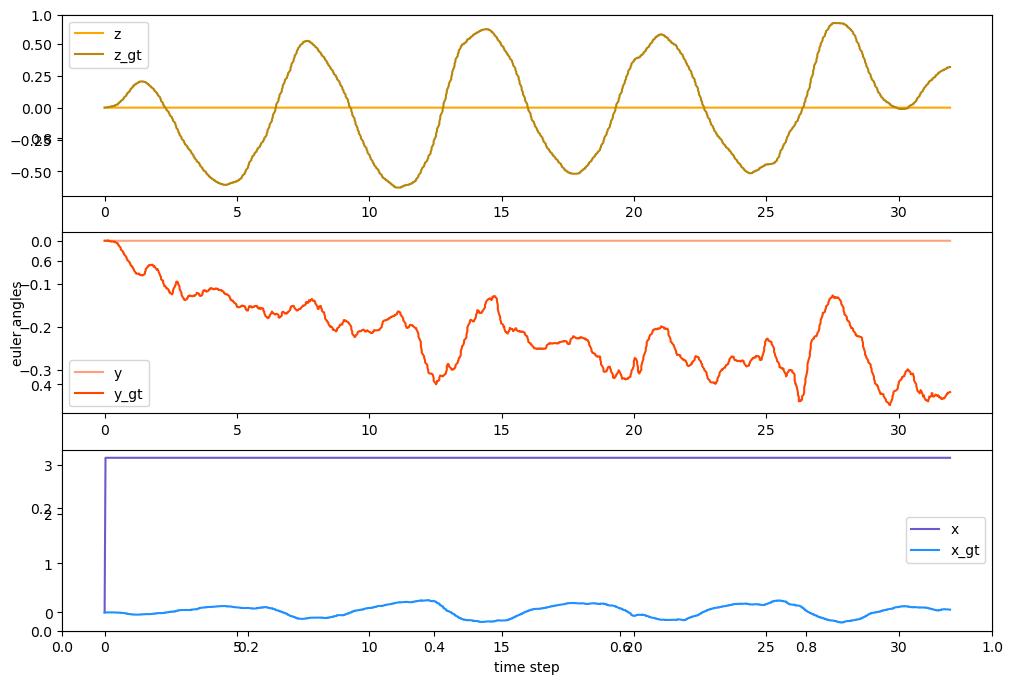

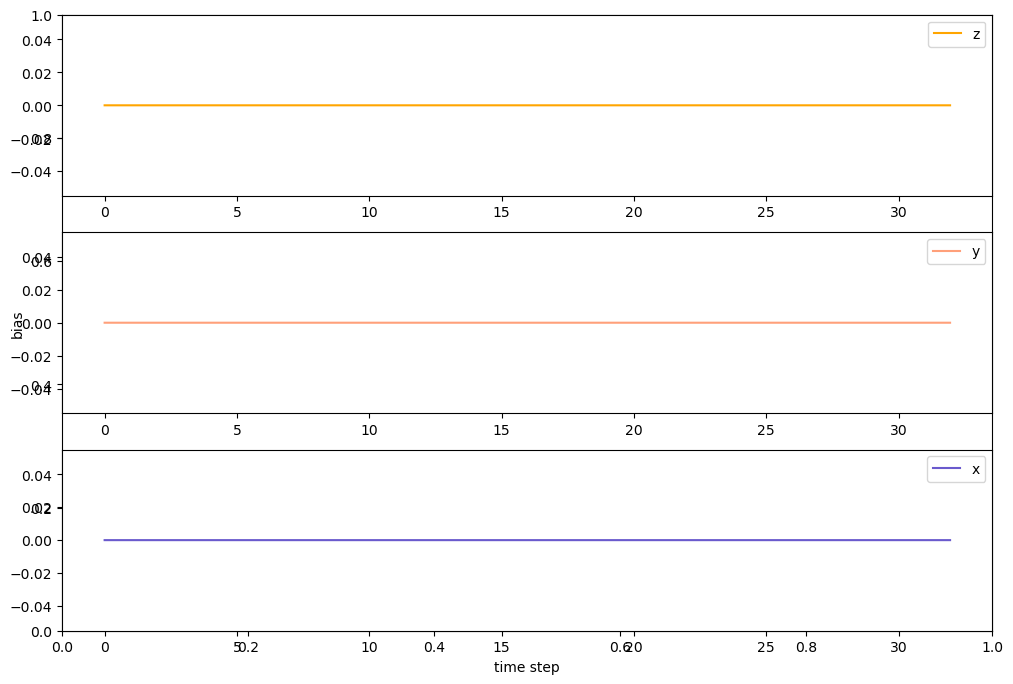

In [ ]:
from ahrs_imperfect_riekf import *
import numpy as np
import matplotlib.pyplot as plt

data = imperfect_riekf_load_data()
inekf_filter = imperfect_right_iekf()
states_euler, bias = ahrs_imperfect_riekf(inekf_filter, data)
euler_gt = data['euler_gt']
dt = data['dt']

# print final state
print('Answer for Problem 2b:')
print('Final x: %.4f, y: %.4f, z: %.4f' % (states_euler[-1,0], states_euler[-1,1], states_euler[-1,2]))

# plot euler angles
fig = plt.figure()
time = np.concatenate(([0],np.cumsum(dt)))

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(time, states_euler[:, 0], label="z", color='orange')
ax1.plot(time, euler_gt[:, 0], label="z_gt", color='darkgoldenrod')
ax2.plot(time, states_euler[:, 1], label="y", color='lightsalmon')
ax2.plot(time, euler_gt[:, 1], label="y_gt", color='orangered')
ax3.plot(time, states_euler[:, 2], label="x", color='slateblue')
ax3.plot(time, euler_gt[:, 2], label="x_gt", color='dodgerblue')

ax1.legend()
ax2.legend()
ax3.legend()

ax.set_xlabel('time step')
ax.set_ylabel('euler angles')

plt.show()

# plot bias
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(time, bias[:, 0], label="z", color='orange', )
ax2.plot(time, bias[:, 1], label="y", color='lightsalmon')
ax3.plot(time, bias[:, 2], label="x", color='slateblue')

ax1.legend()
ax2.legend()
ax3.legend()

ax.set_xlabel('time step')
ax.set_ylabel('bias')

plt.show()